# Comparação de Métodos de Geração de Sinais Sintéticos

Este notebook compara dois métodos de geração de sinais de falha em rolamentos:
1. **Método FFT (Soma de Senóides)**: Baseado no espectro de frequências calculado.
2. **Método Impulso (Resposta ao Impulso)**: Baseado na convolução de um trem de impulsos com a resposta estrutural.

O objetivo é visualizar as diferenças no domínio da frequência (FFT) para validar a qualidade dos sinais gerados.

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Adicionar src ao path
sys.path.append(os.path.abspath('src'))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

# Configurações
RPM = 1730
FS = 12000

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

### 1. Carregar Sinal Normal Base
Usaremos um segmento real 'Normal' com 1730 RPM como ruído de fundo base para ambos os métodos.

In [3]:
normal_seg = None
for k, v in ssd.dicionario_treino.items():
    if v['rotacao_rpm'].iloc[0] == RPM:
        normal_seg = v['amplitude'].values
        print(f"Segmento Normal Carregado: {k}")
        break

if normal_seg is None:
    # Fallback
    k = list(ssd.dicionario_treino.keys())[0]
    normal_seg = ssd.dicionario_treino[k]['amplitude'].values
    print(f"Aviso: RPM exato não encontrado. Usando segmento: {k}")

n = len(normal_seg)
duration = n / FS

Segmento Normal Carregado: 1730_Normal_DE_treino_seg_0


### 2. Funções Auxiliares de Plotagem

In [4]:
def plot_comparison(fault_name, sig_fft_comb, sig_impulse_comb, characteristic_freq=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
    
    # Internal FFT function
    def calc_fft(sig):
        yf = fft(sig)
        xf = fftfreq(len(sig), 1/FS)[:len(sig)//2]
        mag = 2.0/len(sig) * np.abs(yf[0:len(sig)//2])
        return xf, mag

    # Plot 1: FFT Method
    x1_c, y1_c = calc_fft(sig_fft_comb)
    axes[0].plot(x1_c, y1_c, color='black', alpha=0.7, label='Sinal Combinado (Ruído + Falha)')
    if characteristic_freq:
        axes[0].axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Freq. Característica: {characteristic_freq:.1f}Hz')
    
    axes[0].set_title(f"{fault_name} - Método FFT (Soma Senóides)", fontsize=12, fontweight='bold')
    axes[0].set_ylabel("Magnitude")
    axes[0].set_xlim(0, 2000)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')

    # Plot 2: Impulse Method
    x2_c, y2_c = calc_fft(sig_impulse_comb)
    axes[1].plot(x2_c, y2_c, color='black', alpha=0.7, label='Sinal Combinado (Ruído + Falha)')
    if characteristic_freq:
        axes[1].axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Freq. Característica: {characteristic_freq:.1f}Hz')

    axes[1].set_title(f"{fault_name} - Método Impulso (Convolução)", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlabel("Frequência (Hz)")
    axes[1].set_xlim(0, 2000)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right')
    
    plt.show()

### 3. Geração e Comparação por Tipo de Falha

In [5]:
# Preparar geração do método de impulso para todos os tipos de uma vez
# CORREÇÃO: Criar DataFrame corretamente para evitar erro de dimensão
df_dummy = pd.DataFrame({'amplitude': normal_seg})
df_dummy['rotacao_rpm'] = RPM
df_dummy['tipo_falha'] = 'Normal'

dummy_dict = {'temp_normal': df_dummy}

print("Gerando sinais pelo método de Impulso...")
# Usamos multiplicador maior para visualizar bem o impacto
df_impulse = gid.gerar_dados_sinteticos_treino(
    dicionario_treino=dummy_dict,
    TAXA_AMOSTRAL=FS,
    params_drive_end=gid.params_drive_end,
    amplitudes_referencia=gid.amplitudes_referencia,
    multiplicadores=[1], # Amplitude x1 (Realista)
    fases_para_adicionar_rad=[0]
)

Gerando sinais pelo método de Impulso...
Usando 999 modos naturais para Outer Race (primeiro: 5037.1 Hz)
Usando 999 modos naturais para Inner Race (primeiro: 14142.8 Hz)
Gerando Sinais... (damp=0.1, dur=0.1s, mod=0.5)
Geração concluída. Total de 4 segmentos de treino.


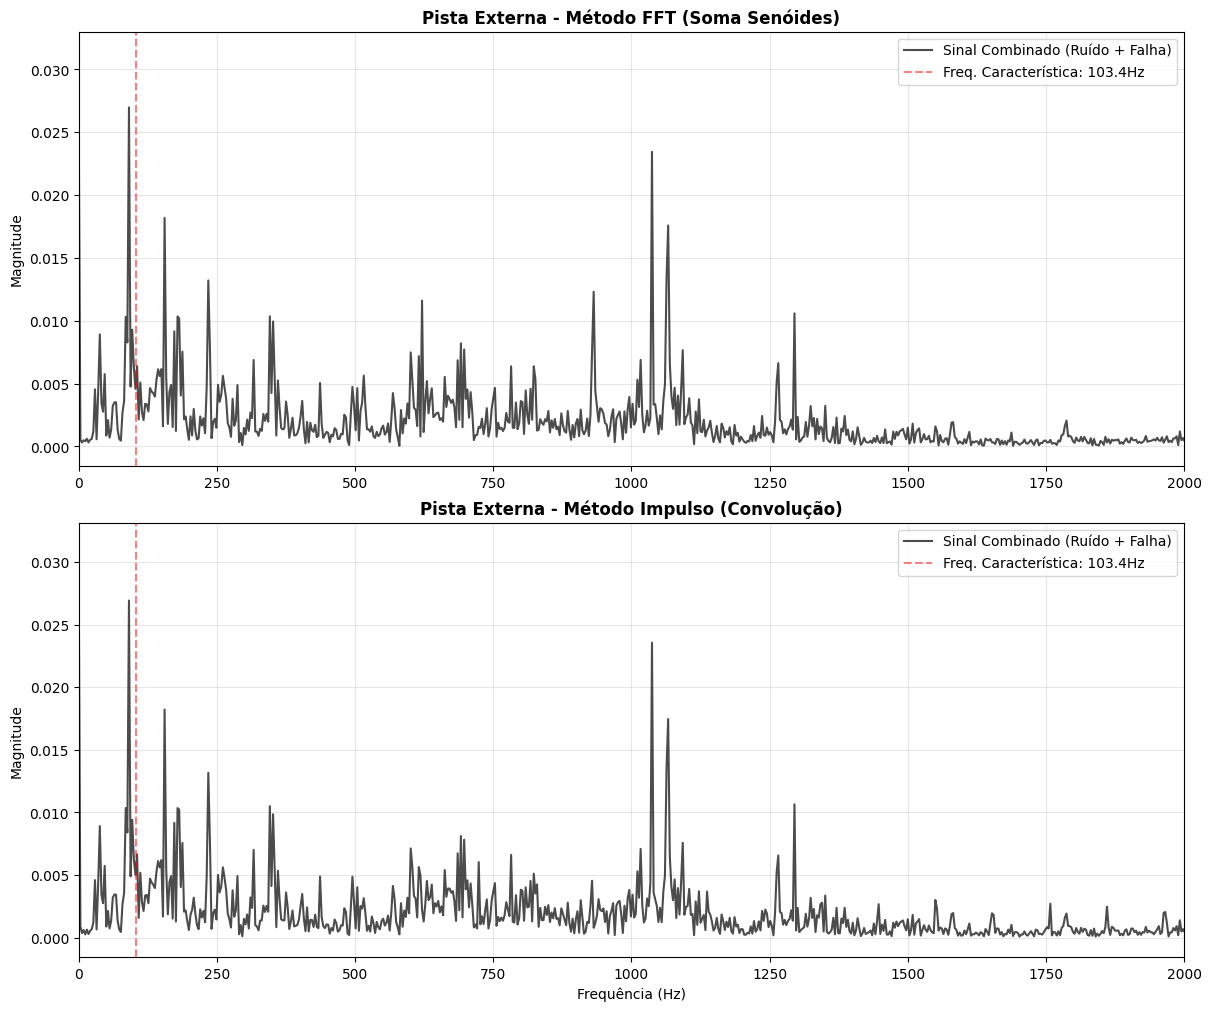

In [6]:
# --- Pista Externa ---

# 1. Gerar FFT Method
spec_outer = bu.calcular_espectro_outer_race(fault_diameter_mm=0.5, rpm=RPM, K=0.008) # Ajuste K para ficar comparável se necessário
sig_outer_gen = gsd.synthesize_time_signal(spec_outer, duration=duration, fs=FS)
# Ajuste de tamanho
sig_outer_gen = sig_outer_gen[:n] if len(sig_outer_gen) > n else np.pad(sig_outer_gen, (0, n - len(sig_outer_gen)))
final_outer_fft = normal_seg + sig_outer_gen

# 2. Pegar Impulse Method
row_outer = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Externa'].iloc[0]
final_outer_imp = row_outer['sinal_final']
final_outer_imp_pure = row_outer['sinal_puro']

# Calculate char freq
coeffs_out = bu.calculate_tandon_coefficients(fault_diameter_mm=0.0, rpm=RPM, fault_type='outer')
freq_out = coeffs_out['frequencies']['defect_freq_hz']
plot_comparison("Pista Externa", final_outer_fft, final_outer_imp, characteristic_freq=freq_out)

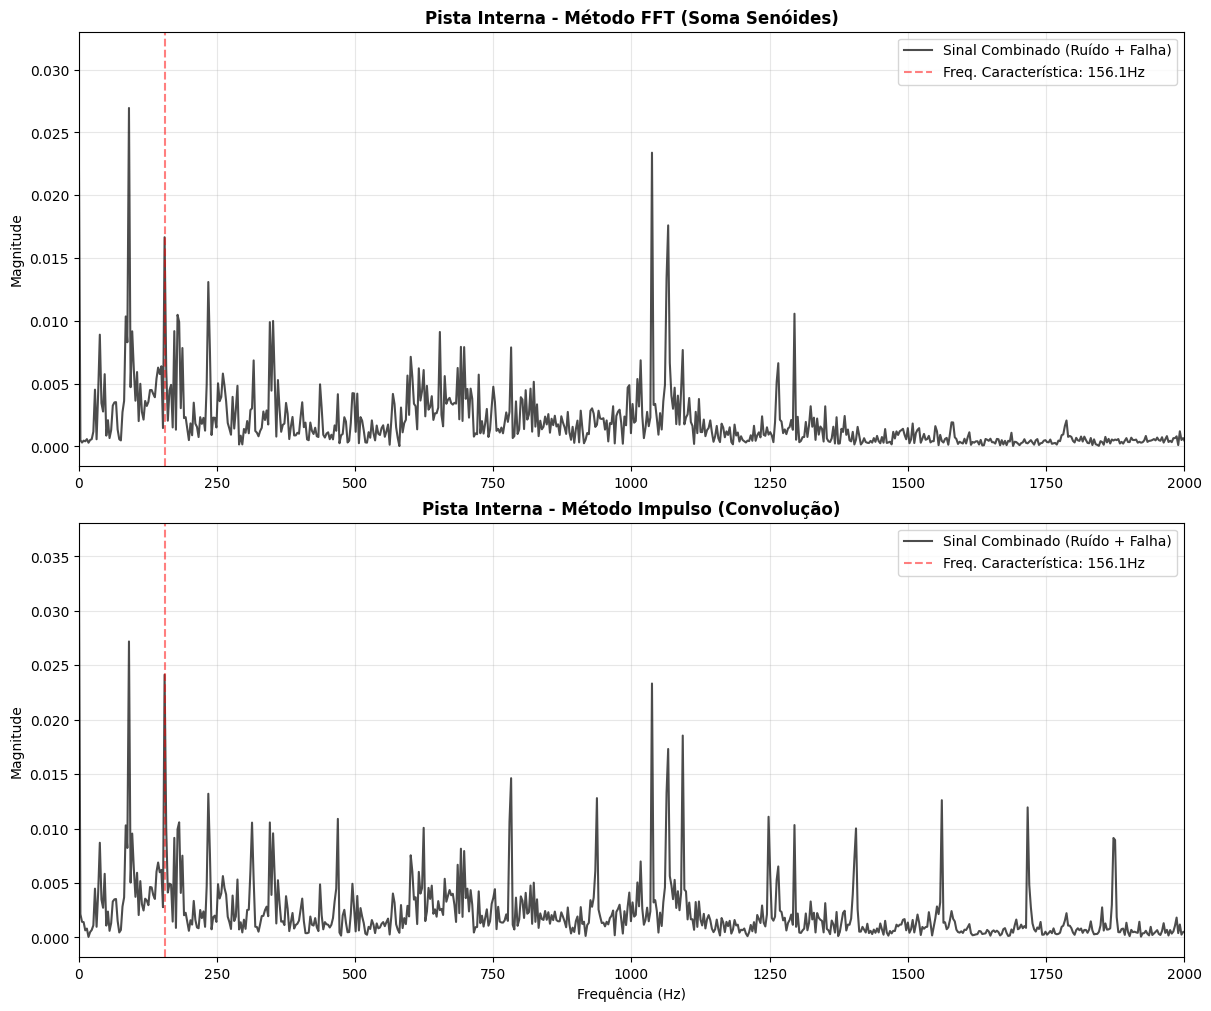

In [7]:
# --- Pista Interna ---

# 1. Gerar FFT Method
spec_inner = bu.calcular_espectro_inner_completo(fault_diameter_mm=0.5, rpm=RPM, K=0.1)
sig_inner_gen = gsd.synthesize_time_signal(spec_inner, duration=duration, fs=FS)
sig_inner_gen = sig_inner_gen[:n] if len(sig_inner_gen) > n else np.pad(sig_inner_gen, (0, n - len(sig_inner_gen)))
final_inner_fft = normal_seg + sig_inner_gen

# 2. Pegar Impulse Method
row_inner = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Interna'].iloc[0]
final_inner_imp = row_inner['sinal_final']
final_inner_imp_pure = row_inner['sinal_puro']

# Calculate char freq
coeffs_in = bu.calculate_tandon_coefficients(fault_diameter_mm=0.0, rpm=RPM, fault_type='inner')
freq_in = coeffs_in['frequencies']['defect_freq_hz']
plot_comparison("Pista Interna", final_inner_fft, final_inner_imp, characteristic_freq=freq_in)

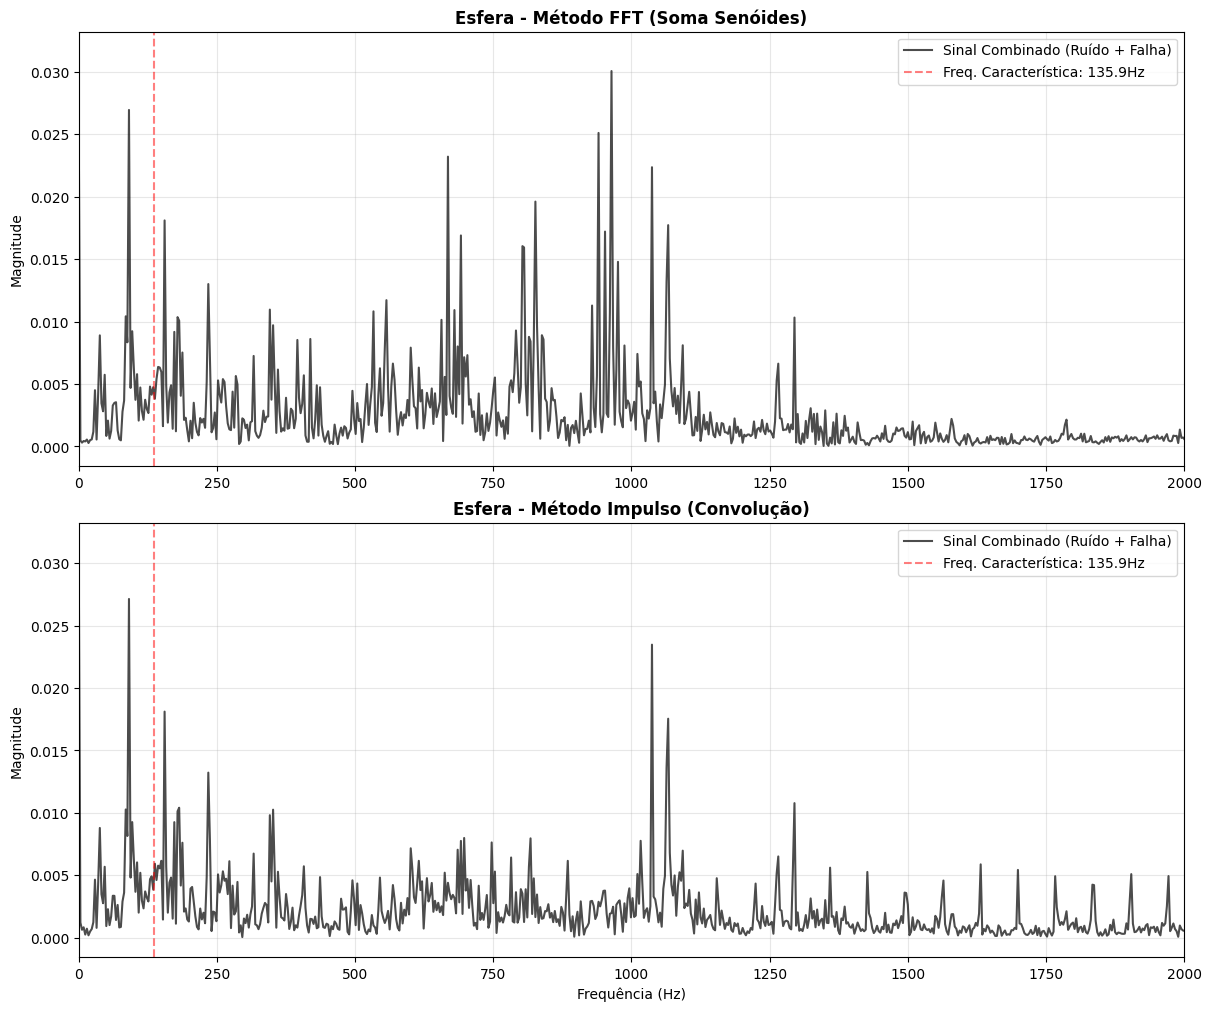

In [8]:
# --- Esfera ---

# 1. Gerar FFT Method
spec_ball = bu.calcular_espectro_ball_completo(fault_diameter_mm=0.5, rpm=RPM, K=0.05)
sig_ball_gen = gsd.synthesize_time_signal(spec_ball, duration=duration, fs=FS)
sig_ball_gen = sig_ball_gen[:n] if len(sig_ball_gen) > n else np.pad(sig_ball_gen, (0, n - len(sig_ball_gen)))
final_ball_fft = normal_seg + sig_ball_gen

# 2. Pegar Impulse Method
row_ball = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Esfera'].iloc[0]
final_ball_imp = row_ball['sinal_final']
final_ball_imp_pure = row_ball['sinal_puro']

# Calculate char freq
coeffs_ball = bu.calculate_tandon_coefficients(fault_diameter_mm=0.0, rpm=RPM, fault_type='ball')
freq_ball = coeffs_ball['frequencies']['defect_freq_hz']
plot_comparison("Esfera", final_ball_fft, final_ball_imp, characteristic_freq=freq_ball)

## 4. Comparação Quantitativa: Spectral Angle Mapper (SAM)
O código abaixo busca sinais reais no `dicionario_teste` filtrando explicitamente pelo valor na coluna `diametro_falha`. 
Alvo: **0.021"** (aproximadamente 0.5mm).

In [15]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.fft import fft
import random

def calcular_sam_graus(fft_ref, fft_alvo):
    if np.iscomplexobj(fft_ref): fft_ref = np.abs(fft_ref)
    if np.iscomplexobj(fft_alvo): fft_alvo = np.abs(fft_alvo)
    min_len = min(len(fft_ref), len(fft_alvo))
    dist = cosine(fft_ref[:min_len], fft_alvo[:min_len])
    sim = np.clip(1.0 - dist, -1.0, 1.0)
    return np.degrees(np.arccos(sim))

def get_mag_spectrum(sig):
    yf = fft(sig)
    return 2.0/len(sig) * np.abs(yf[0:len(sig)//2])


In [21]:
def get_real_signals_metadata_batch(rpm, type_code, target_dia_str='0.021"', num_samples=20):
    # Mapeamento do código de tipo (OR, IR, B) para o nome usado em 'tipo_falha' no DataFrame
    # Baseado em mapa_tipo_falha = {'IR': 'Pista Interna', 'B': 'Esfera', 'OR': 'Pista Externa'}
    type_map = {'OR': 'Pista Externa', 'IR': 'Pista Interna', 'B': 'Esfera'}
    target_type = type_map.get(type_code, type_code)
    
    candidates = []
    
    # Iterar sobre todos os items do dicionário
    for chave, df in ssd.dicionario_teste.items():
        # Verificar se não é vazio
        if df.empty:
            continue
            
        # Checar metadata na primeira linha (todos segmentos tem mesmo metadata)
        try:
            # Converter para string para evitar problemas de tipo
            row_rpm = int(df['rotacao_rpm'].iloc[0])
            row_type = str(df['tipo_falha'].iloc[0])
            row_dia = str(df['diametro_falha'].iloc[0]).replace('"', '').strip() # Remove aspas para comparação segura
            
            target_dia_clean = target_dia_str.replace('"', '').strip()
            
            # Lógica de match aprox para RPM (ex: 1730 vs 1750)
            if abs(row_rpm - rpm) < 50: # Tolerância de 50 rpm
                if row_type == target_type:
                    # Comparação de diâmetro
                    if row_dia == target_dia_clean:
                        candidates.append((chave, df['amplitude'].values))
        except Exception as e:
            # Ignorar dataframes mal formatados
            continue
            

    if not candidates:
       print("AVISO: Nenhum candidato exato encontrado. Tentando fallback para qualquer diâmetro...")
       # Fallback: ignore diameter if specific one not found
       for chave, df in ssd.dicionario_teste.items():
            if df.empty: continue
            try:
                row_rpm = int(df['rotacao_rpm'].iloc[0])
                row_type = str(df['tipo_falha'].iloc[0])
                if abs(row_rpm - rpm) < 50 and row_type == target_type:
                     candidates.append((chave, df['amplitude'].values))
            except: continue
    
    # Selecionar aleatórios
    if len(candidates) > num_samples:
        selected = random.sample(candidates, num_samples)
    else:
        selected = candidates
        
    return selected

# ------------- EXECUÇÃO ----------------
mapa_falhas = [
    ('Outer Race', 'OR', final_outer_fft, final_outer_imp),
    ('Inner Race', 'IR', final_inner_fft, final_inner_imp),
    ('Ball', 'B', final_ball_fft, final_ball_imp)
]

print(f"{'Tipo Falha':<15} | {'Nº Refs':<7} | {'SAM FFT (Média)':<20} | {'SAM Impulso (Média)':<20}")
print("-"*90)

for nome_falha, codigo, sig_fft_metodo, sig_imp_metodo in mapa_falhas:
    # Buscar lote de sinais reais com target explicito 0.021"
    refs = get_real_signals_metadata_batch(RPM, codigo, target_dia_str='0.021"', num_samples=20)
    
    if refs:
        sam_fft_vals = []
        sam_imp_vals = []
        
        syn_fft_spec = get_mag_spectrum(sig_fft_metodo)
        syn_imp_spec = get_mag_spectrum(sig_imp_metodo)
        
        for chave_real, sinal_real in refs:
            ref_spec = get_mag_spectrum(sinal_real)
            sam_fft_vals.append(calcular_sam_graus(ref_spec, syn_fft_spec))
            sam_imp_vals.append(calcular_sam_graus(ref_spec, syn_imp_spec))
            
        avg_fft = np.mean(sam_fft_vals)
        std_fft = np.std(sam_fft_vals)
        avg_imp = np.mean(sam_imp_vals)
        std_imp = np.std(sam_imp_vals)
        
        res_fft = f"{avg_fft:.2f} +/- {std_fft:.1f}°"
        res_imp = f"{avg_imp:.2f} +/- {std_imp:.1f}°"
        
        print(f"{nome_falha:<15} | {len(refs):<7} | {res_fft:<20} | {res_imp:<20}")
    else:
        print(f"{nome_falha:<15} | {'0':<7} | {'-':<20} | {'-':<20}")

Tipo Falha      | Nº Refs | SAM FFT (Média)      | SAM Impulso (Média) 
------------------------------------------------------------------------------------------
Outer Race      | 20      | 83.91 +/- 0.5°       | 82.09 +/- 0.4°      
Inner Race      | 20      | 81.70 +/- 2.1°       | 77.63 +/- 2.0°      
Ball            | 20      | 78.09 +/- 1.6°       | 74.92 +/- 1.0°      
